## The Two Moons Model

In this notebook, we learn the posterior of the ``two-moons`` model. This model consists of a latent variable $\theta \in \mathbb{R}^2$, several auxiliary latent variables, and an observation $x \in \mathbb{R}^2$. The model is constructed such that the posterior $\theta \mid x$ resembles two cresent moons facing each other. See section A.5.1 of Greenberg et al. (https://arxiv.org/pdf/1905.07488.pdf) for more details. Below, we show a sample posterior for a random data point drawn from the model. The posterior is evaluated on a fine mesh grid over the prior, which is uniform on a square.

In [1]:
import sys
sys.path.append('../')
from smc.smc_sampler import LikelihoodTemperedSMC
import torch
import math
import torch.distributions as D
import matplotlib.pyplot as plt
import torch.nn as nn

def get_p(r, a):
    one = r*torch.cos(a)+.25
    two = r*torch.sin(a)
    return torch.stack([one, two])

def get_x(r, a, theta):
    p_val = get_p(r, a)
    new1 = -1*torch.sum(theta, -1).abs()/math.sqrt(2)
    new2 = (-1*theta[..., 0]+theta[..., 1])/math.sqrt(2)
    new = torch.stack([new1, new2])
    return (p_val+new).T

def generate_data(n_pts, return_theta=False):
    prior = D.Uniform(torch.tensor([-1., -1.]), torch.tensor([1., 1.]))
    a_dist = D.Uniform(-math.pi/2, math.pi/2)
    r_dist = D.Normal(0.1, .01)

    theta, a, r = prior.sample((n_pts,)), a_dist.sample((n_pts,)), r_dist.sample((n_pts,))
    x = get_x(r, a, theta)
    if return_theta: 
        return theta, x
    else:
        return x

In [2]:
true_x = generate_data(1)
true_x

tensor([[-0.0534, -0.6003]])

In [3]:
prior = prior = D.Uniform(torch.tensor([-1., -1.]), torch.tensor([1., 1.]))
a_dist = D.Uniform(-math.pi/2, math.pi/2)
r_dist = D.Normal(0.1, .01)

kwargs = {'prior': prior,
        'a_dist': a_dist,
        'r_dist': r_dist,
        }

In [4]:
def log_post(x, theta, **kwargs):
    '''vectorized version of log posterior in theta for fixed x.
    Evaluated on a grid of theta values for a single x.'''
    assert theta.shape[1] == 2
    r_dist = kwargs['r_dist']
    new1 = -1*torch.sum(theta, 1).abs()/math.sqrt(2)
    new2 = (-1*theta[:,0]+theta[:,1])/math.sqrt(2)
    new = torch.stack([new1, new2]).T
    p = x-new
    u = p[:,0]-.25
    v = p[:,1]
    r = torch.sqrt(u ** 2 + v ** 2)  # note the angle distribution is uniform
    to_adjust = r_dist.log_prob(r)
    adjusted = torch.where(u < 0.0, -torch.inf, to_adjust.double())
    return adjusted

/home/declan/current/likelihood_tempered_smc/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Exact Posterior')

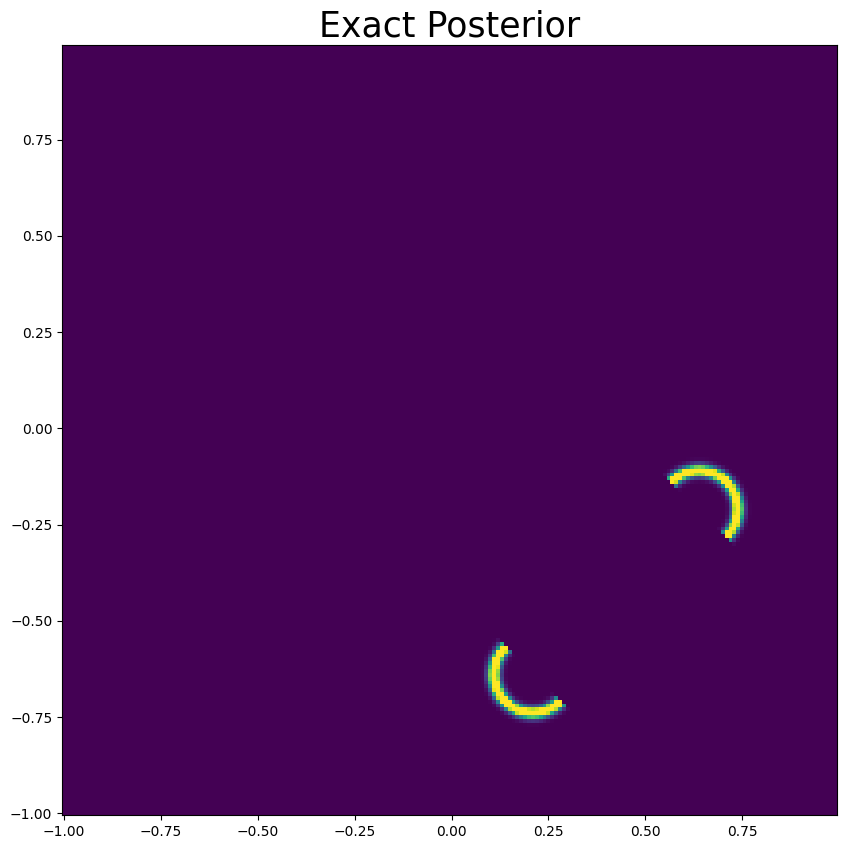

In [5]:
# Plot the exact posterior
fig, ax = plt.subplots(figsize=(10,10))
val = 1. #matches the prior in generate_data.
vals = torch.arange(-val, val, .01)
eval_pts = torch.cartesian_prod(vals, vals)
lps = log_post(true_x[0], eval_pts, **kwargs)
X, Y = torch.meshgrid(vals, vals)
Z = lps.view(X.shape)
ax.pcolormesh(X.numpy(), Y.numpy(), Z.exp().numpy(), vmax=30.0)
ax.set_title('Exact Posterior', fontsize=25)

If you haven't already, please read the documentation in the Gaussian.ipynb notebook, which explains the three functions below more in-depth. If you have already worked through that notebook, you'll recognize the form of the `log_target`, `log_prior`, and `proposal` functions.

In [6]:
def log_target(z_batch, context, **kwargs):
    '''
    Essentially identical to posterior above because prior is uniform.
    '''
    r_dist = kwargs['r_dist']
    theta = z_batch
    new1 = -1*torch.sum(theta, 1).abs()/math.sqrt(2)
    new2 = (-1*theta[:,0]+theta[:,1])/math.sqrt(2)
    new = torch.stack([new1, new2]).T
    p = context-new
    u = p[:,0]-.25
    v = p[:,1]
    r = torch.sqrt(u ** 2 + v ** 2)  # note the angle distribution is uniform
    to_adjust = r_dist.log_prob(r)
    adjusted = torch.where(u < 0.0, -torch.inf, to_adjust.double())

    return adjusted

def log_prior(z_batch, **kwargs):
    prior = kwargs['prior']
    theta = z_batch
    lps = prior.log_prob(theta) # for our problem, N x len(true_x)
    return lps.sum(-1) #sum over last dimension for shaping

def mh_step(z_batch, context, target_fcn, **kwargs):
    noise = 0.1
    proposed_particles = D.Normal(z_batch, noise).sample().clamp(min=-1., max=1.)
    lps_curr = torch.nan_to_num(target_fcn(z_batch), -torch.inf)
    lps_new = torch.nan_to_num(target_fcn(proposed_particles), -torch.inf)
    lp_ratios = torch.nan_to_num(lps_new - lps_curr, -torch.inf)
    lp_ratios = torch.exp(lp_ratios).clamp(min=0., max=1.)
    flips = D.Bernoulli(lp_ratios).sample()
    indices_old = torch.arange(len(flips))[flips == 0]
    indices_new = torch.arange(len(flips))[flips == 1]
    new = torch.empty(proposed_particles.shape)
    new[indices_new] = proposed_particles[indices_new]
    new[indices_old] = z_batch[indices_old]
    return new

def proposal(params, context, target_fcn, **kwargs):
    new = params
    for _ in range(5):
        new = mh_step(new, context, target_fcn, **kwargs)
    return new

Now let's run instantiate and run the `LikelihoodTemperedSMC` object.

In [7]:
K = 1000
particles = prior.sample((K,))
particles = particles.unsqueeze(1)
init_log_weights = torch.zeros((K, 1))
init_weights = (nn.Softmax(0)(init_log_weights)).view(-1)
final_target_fcn = lambda z: log_prior(z, **kwargs)+log_target(z,true_x[0], **kwargs)
SMC = LikelihoodTemperedSMC(particles, init_weights, init_log_weights, final_target_fcn, prior, log_prior, log_target, proposal, max_mc_steps=100, context=true_x[0].cpu(), kwargs=kwargs)
SMC.run()

0.0002400197781067123
0.0006697408670251821
0.004789601376831729
0.011683146894752836
0.09891410511320146
0.4063067260208546
1.0


/home/declan/current/likelihood_tempered_smc/examples/../smc/smc_sampler.py:108: RuntimeWarning: invalid value encountered in multiply
  log_numerator = 2 * lse(np.nan_to_num(delta * log_targets, nan=-np.inf))
/home/declan/current/likelihood_tempered_smc/examples/../smc/smc_sampler.py:109: RuntimeWarning: invalid value encountered in multiply
  log_denominator = lse(2 * np.nan_to_num(delta * log_targets, nan=-np.inf))
/home/declan/current/likelihood_tempered_smc/examples/../smc/smc_sampler.py:109: RuntimeWarning: overflow encountered in multiply
  log_denominator = lse(2 * np.nan_to_num(delta * log_targets, nan=-np.inf))


Let's evaluate how well the LTSMC sampler performs. We can construct a 2D histogram of samples drawn from the sampler and compare to the true posterior.

Text(0.5, 1.0, 'Exact Posterior')

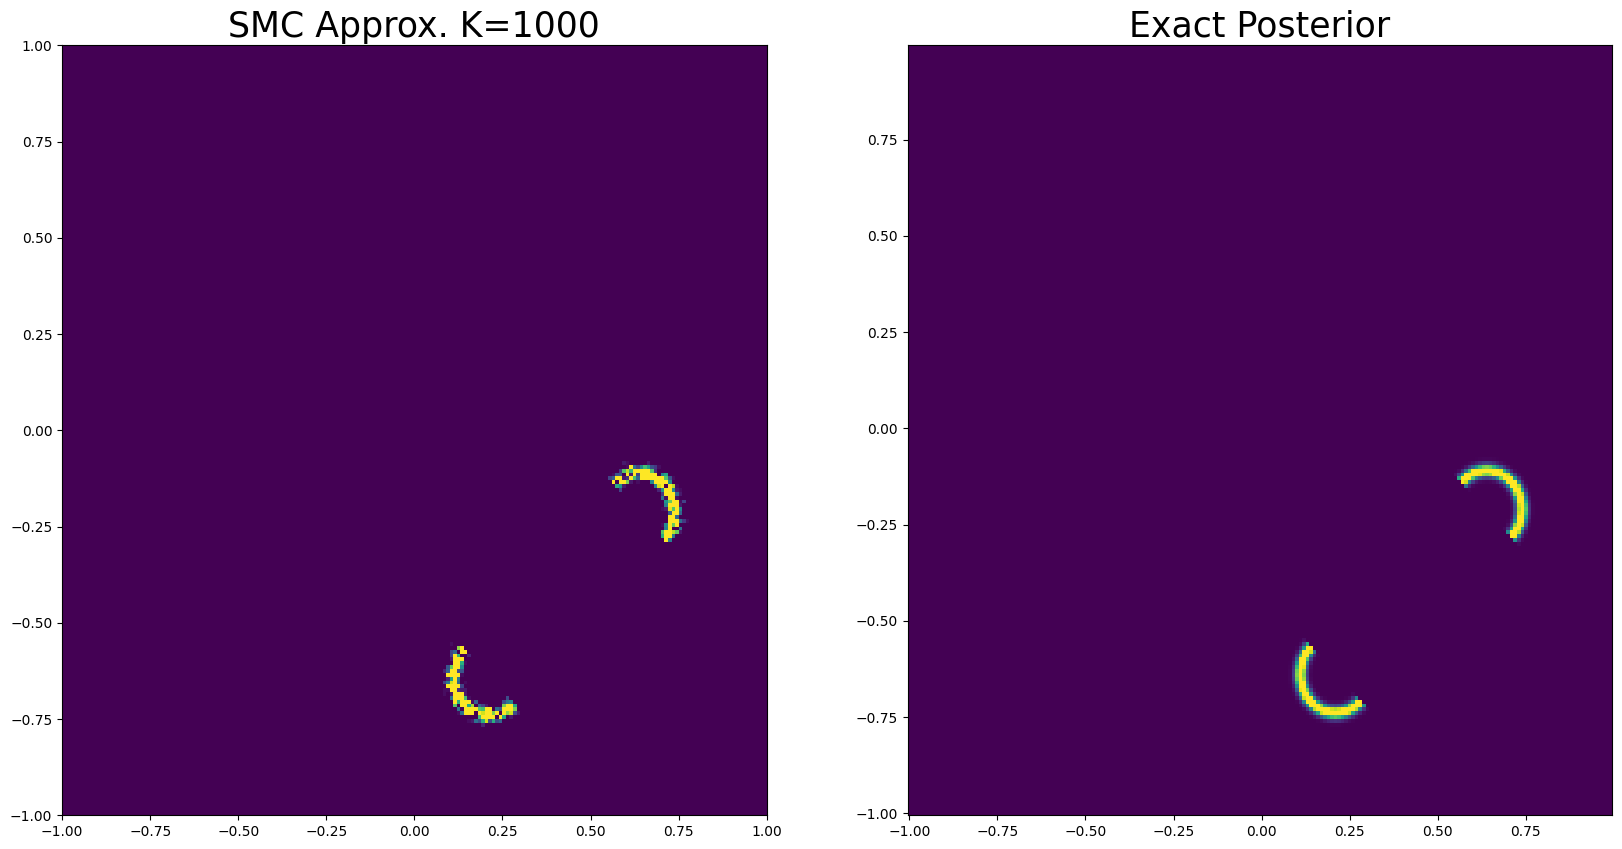

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
samples = SMC.sampler.current_ed.sample(10000)[:, -1, ...]
ax[0].hist2d(samples[:,0].detach().numpy(), samples[:,1].detach().numpy(), bins=200, range=[[-1.,1.], [-1.,1.]], vmax=30.0)
ax[0].set_title('SMC Approx. K={}'.format(K), fontsize=25)

ax[1].pcolormesh(X.numpy(), Y.numpy(), Z.exp().numpy(), vmax=30.0)
ax[1].set_title('Exact Posterior', fontsize=25)

We can see that the shape and suport of the posterior are captured well. The ``SMC`` object contains a `sampler` that retains a "history" of sorts of how the particles evolve. Really, weights are assigned to the whole chain of particles. 

In [9]:
SMC.sampler.current_ed.items.shape

torch.Size([1000, 8, 2])

In [10]:
len(SMC.tau_list)

8

In [11]:
SMC.tau_list

[0.0,
 0.0002400197781067123,
 0.0006697408670251821,
 0.004789601376831729,
 0.011683146894752836,
 0.09891410511320146,
 0.4063067260208546,
 1.0]

The dimensions are for $K=1000$ particles, $10$ tempering stages, and dimension $2$ for each particle. We can plot to see how the empirical distribution of particles evolves across tempering steps.

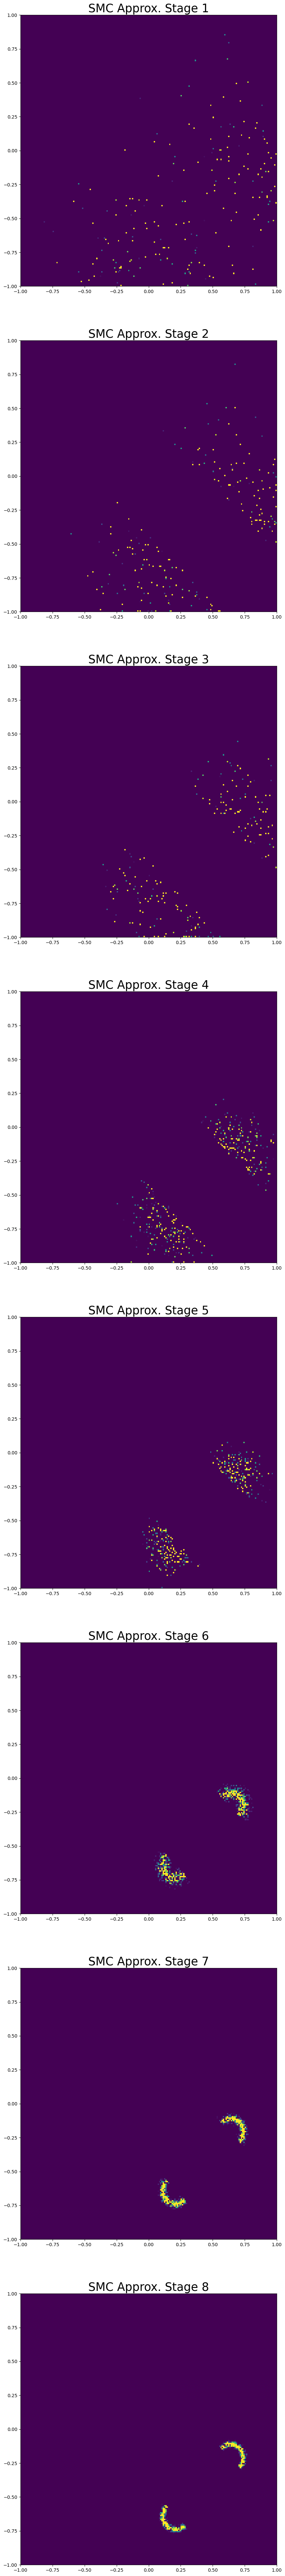

In [12]:
fig, ax = plt.subplots(nrows=len(SMC.tau_list), ncols=1, figsize=(10,100))
samples = SMC.sampler.current_ed.sample(10000)#[:, -1, ...]
for j in range(len(SMC.tau_list)):
    ax[j].hist2d(samples[:,j,...][:,0].detach().numpy(), samples[:,j,...][:,1].detach().numpy(), bins=200, range=[[-1.,1.], [-1.,1.]], vmax=30.0)
    ax[j].set_title('SMC Approx. Stage {}'.format(j+1), fontsize=25)


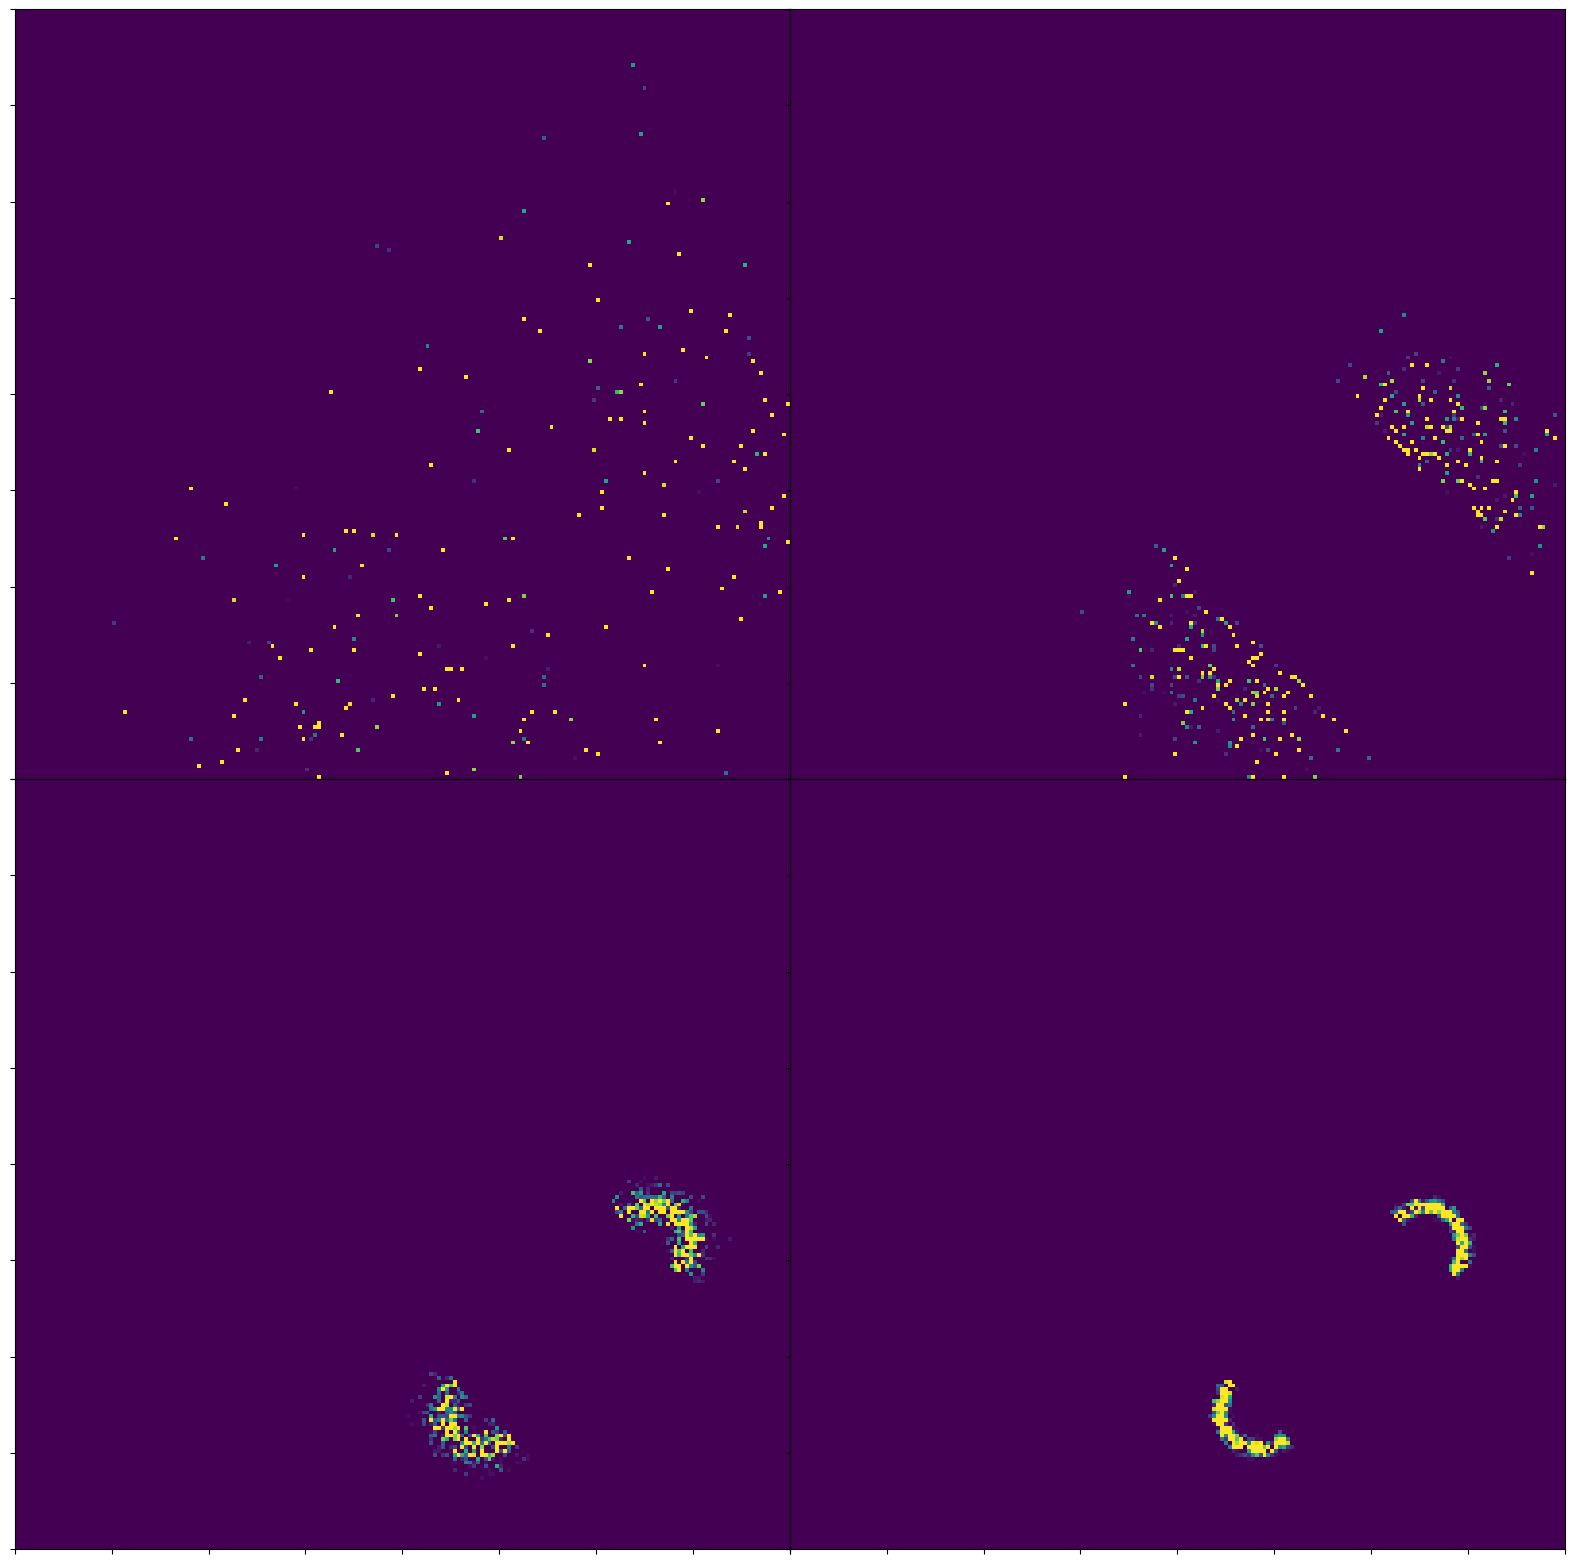

In [13]:
indices = [0,3,5,7]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
samples = SMC.sampler.current_ed.sample(10000)#[:, -1, ...]
for num in range(len(indices)):
    j = indices[num]
    row = num // 2
    col = num % 2
    ax[row,col].hist2d(samples[:,j,...][:,0].detach().numpy(), samples[:,j,...][:,1].detach().numpy(), bins=200, range=[[-1.,1.], [-1.,1.]], vmax=30.0)
    ax[row,col].set_xticklabels([])
    ax[row,col].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("cover_fig.png", bbox_inches='tight')